In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import datetime
import sklearn
import pickle


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2022-08-12 14:32:06.268479: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-12 14:32:06.304259: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-12 14:32:06.304274: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
 # !pip install tensorflow

In [4]:
# import mlflow
# from mlflow.models.signature import infer_signature
# mlflow.set_tracking_uri("http://127.0.0.1:5000/")
# mlflow.set_experiment("Handwriting-rating")

In [5]:
import pathlib
data_dir = pathlib.Path("/home/snekha/datasets/images")

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1000


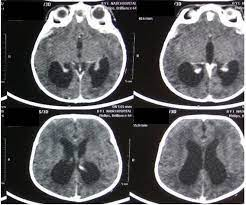

In [7]:
depressed = list(data_dir.glob('depressed/*'))
PIL.Image.open(str(depressed[0]))

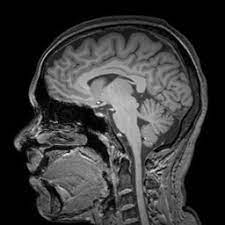

In [8]:
healthy = list(data_dir.glob('healthy/*'))
PIL.Image.open(str(healthy[0]))

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
     image_size=(256,256),
  subset="training",
  seed=123)

Found 1000 files belonging to 2 classes.
Using 800 files for training.


2022-08-12 14:32:08.260496: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-12 14:32:08.260514: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-12 14:32:08.260524: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (snekha): /proc/driver/nvidia/version does not exist
2022-08-12 14:32:08.261255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
    image_size=(256,256),
  subset="validation",
  seed=123)

Found 1000 files belonging to 2 classes.
Using 200 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['depressed', 'healthy']


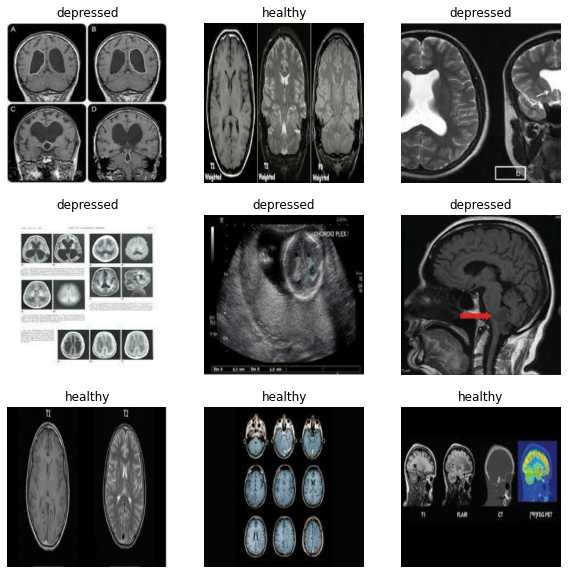

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [17]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',f1_m,precision_m, recall_m])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
25/25 [==============================] - 5s 195ms/step - loss: 0.9770 - accuracy: 0.5263 - f1_m: 0.1065 - precision_m: 0.0841 - recall_m: 0.1467 - val_loss: 0.6725 - val_accuracy: 0.5950 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/10
25/25 [==============================] - 5s 186ms/step - loss: 0.6309 - accuracy: 0.6363 - f1_m: 0.1711 - precision_m: 0.4175 - recall_m: 0.1153 - val_loss: 0.7624 - val_accuracy: 0.5050 - val_f1_m: 0.4465 - val_precision_m: 0.7937 - val_recall_m: 0.3286
Epoch 3/10
25/25 [==============================] - 5s 193ms/step - loss: 0.5643 - accuracy: 0.7212 - f1_m: 0.3073 - precision_m: 0.5505 - recall_m: 0.2298 - val_loss: 0.6643 - val_accuracy: 0.6600 - val_f1_m: 0.5272 - val_precision_m: 0.6869 - val_recall_m: 0.4418
Epoch 4/10
25/25 [==============================] - 5s 183ms/step - loss: 0.4546 - accuracy: 0.7950 - f1_m: 0.4723 - precision_m: 0.5330 - recall_m: 0.4313 - val_loss: 0.5761 - val_accuracy:

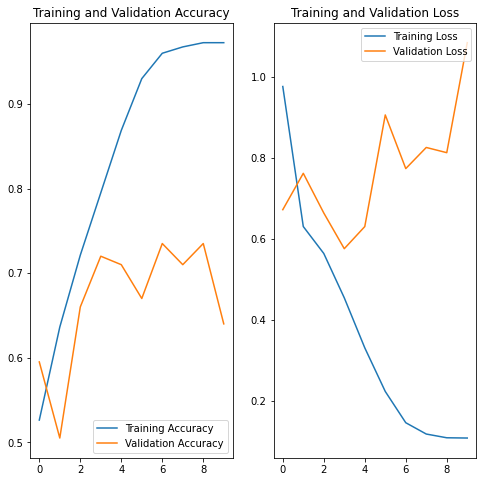

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:


loss, accuracy, f1_score, precision, recall = model.evaluate(train_ds, verbose=0)

print([accuracy,f1_score,precision,recall])

[0.981249988079071, 0.703940212726593, 0.5545522570610046, 0.9775747060775757]


In [24]:
history.history

{'loss': [0.9770001173019409,
  0.6308711767196655,
  0.5642660856246948,
  0.45460960268974304,
  0.33098533749580383,
  0.22314541041851044,
  0.1458509862422943,
  0.11787490546703339,
  0.10864302515983582,
  0.10800246149301529],
 'accuracy': [0.5262500047683716,
  0.6362500190734863,
  0.7212499976158142,
  0.7950000166893005,
  0.8687499761581421,
  0.9300000071525574,
  0.9599999785423279,
  0.9674999713897705,
  0.9725000262260437,
  0.9725000262260437],
 'f1_m': [0.10654613375663757,
  0.1711340844631195,
  0.3073335886001587,
  0.4723139703273773,
  0.516914427280426,
  0.5889056921005249,
  0.626440703868866,
  0.6328632831573486,
  0.6537102460861206,
  0.6490179300308228],
 'precision_m': [0.08413461595773697,
  0.41750794649124146,
  0.5505036115646362,
  0.5330019593238831,
  0.4812740385532379,
  0.5077113509178162,
  0.5120438933372498,
  0.4993855953216553,
  0.5099809169769287,
  0.5041031837463379],
 'recall_m': [0.14666667580604553,
  0.11533817648887634,
  0.2298

In [25]:
fil = "/home/snekha/Pictures/Screenshot from 2022-08-12 14-30-06.png"

img = tf.keras.utils.load_img(
    fil, target_size=(256, 256)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 61ms/step
This image most likely belongs to healthy with a 63.72 percent confidence.


In [26]:
#/home/snekha/datasets/jpg_23.jpg good
#/home/snekha/datasets/bad.png bad

In [27]:
# import pandas as pd
# categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
# categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
# confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

# #To get better visual of the confusion matrix:
# def plot_confusion_matrix(cm, classes,
#    normalize=False,
#    title="Confusion matrix",
#    cmap=plt.cm.Blues):
 
# #Add Normalization Option
#  '''prints pretty confusion metric with normalization option '''
# if normalize:
#      cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
#      print("Normalized confusion matrix")
# else:
#      print("Confusion matrix, without normalization")
 
# # print(cm)
 
# plt.imshow(cm, interpolation="nearest", cmap=cmap)
# plt.title(title)
# plt.colorbar()
# tick_marks = np.arange(len(classes))
# plt.xticks(tick_marks, classes, rotation=45)
# plt.yticks(tick_marks, classes)
 
# fmt = ".2f" if normalize else "d"
# thresh = cm.max() / 2.
# for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#   plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
 
# plt.tight_layout()
# plt.ylabel("True label")
# plt.xlabel("Predicted label") 

In [36]:
pickle.dump(model, open('mri_model.pkl','wb'))

INFO:tensorflow:Assets written to: ram://f7bf02a0-089b-4ef8-b638-022e2423d0ea/assets


INFO:tensorflow:Assets written to: ram://f7bf02a0-089b-4ef8-b638-022e2423d0ea/assets


In [40]:
model.save('mri_model')

INFO:tensorflow:Assets written to: mri_model/assets


INFO:tensorflow:Assets written to: mri_model/assets
